# RNN for Last Name Classification

We will train a neural network to predict the probable language of origin for a given last name / family name in Latin alphabets.


## Download Data

In [2]:
import os

if not os.path.exists("data"):
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data

--2025-02-22 16:18:24--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.165.102.62, 3.165.102.113, 3.165.102.31, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.165.102.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  2.16MB/s    in 1.3s    

2025-02-22 16:18:26 (2.16 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Itali

## Library imports

Before starting, make sure you have all these libraries.

In [3]:
root_folder = ""
import os
import sys
import inspect
sys.path.append(root_folder)
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import random
import numpy as np
import json

import matplotlib.pyplot as plt
# from utils import validate_to_array

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import IPython
from ipywidgets import interactive, widgets, Layout
from IPython.display import display, HTML

In [4]:
%load_ext autoreload
%autoreload 2

## Implementing the Neural Network

The main objective of this task is to predict the probability of a given class given a last name, represented as

$$ \Pr ( y | x_1, x_2, x_3, ..., x_i),$$

where $y$ is the category label and each $x_i$ is a character in the last name. Building a basic character-level NLP model has the advantage of understanding how the preprocessing works at a granular level. The character-level network reads words as a sequence of characters, producing a prediction and "hidden state" at each step by feeding its previous hidden state into the next step. The final prediction corresponds to the class to which the word belongs.

The forward pass of the model can be visualized with the following diagram:

```
[Embedding] -> [RNN Stack] -> [Extract Last Position] -> [Classifier]
```

- **Embedding:** This component maps each input word (integer) to a vector of real numbers.
    - Input: `[batch_size, seq_len]`
    - Output: `[batch_size, seq_len, rnn_size]`
- **RNN Stack:** This component consists of one or more RNN layers, which process the input sequence of vectors from the Embedding component.
    - Input: `[batch_size, seq_len, rnn_size]`
    - Output: `[batch_size, seq_len, rnn_size]`
- **Extract Last Position:** The RNN Stack component returns a sequence of vectors for each input example. However, for classification purposes, we only need a single vector that captures the full information of the input example. Since the RNN is left-to-right by default, the output state vector at the last position contains the full information of the input example. Therefore, for the $i$-th input example, we extract the output state vector at the last *non-pad* position, which is indicated by `last_pos[i]`.
    - Input: `[batch_size, seq_len, rnn_size]`
    - Output: `[batch_size, rnn_size]`
- **Classifier:** This component is a fully-connected layer that maps the output vectors extracted in the previous step to logits (scores before softmax), which can be used to make predictions about the language of origin for each input example.
    - Input: `[batch_size, rnn_size]`
    - Output: `[batch_size, n_categories]`


In [14]:
class RecurrentClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        rnn_size: int,
        n_categories: int,
        num_layers: int = 1,
        dropout: float = 0.0,
        model_type: str = 'lstm'
    ):
        super().__init__()
        self.rnn_size = rnn_size
        self.model_type = model_type
        self.embedding = nn.Embedding(vocab_size, self.rnn_size)

        if model_type == 'lstm':
            self.lstm = torch.nn.LSTM(rnn_size, rnn_size, num_layers, batch_first=True, dropout=dropout)
        elif model_type == 'rnn':
            self.rnn = torch.nn.RNN(rnn_size, rnn_size, num_layers, batch_first=True, dropout=dropout)
        self.drop = torch.nn.Dropout(dropout)
        self.output = torch.nn.Linear(rnn_size, n_categories)

    def forward(self, x: torch.Tensor, last_pos: torch.Tensor) -> torch.Tensor:
        """
        x: integer tensor of shape [batch_size, seq_len]
        last_pos: integer tensor of shape [batch_size]

        The input tensor `x` is composed of a batch of sequences, where each
        sequence contains indices corresponding to characters. As sequences
        within the same batch may have different lengths, shorter sequences are
        padded on the right side to match the maximum sequence length of the
        batch, which is represented by `seq_len`.

        Additionally, the `last_pos` tensor records the position of the last
        character in each sequence. For instance, the first sequence in the
        batch can be represented as `[x[0, 0], x[0, 1], ..., x[0, last_pos[0]]`.
        `last_pos` is useful when extracting the output state associated with
        each sequence from the RNNs.
        """
        embeds = self.embedding(x)
        if self.model_type == 'lstm':
            rnn_out, _ = self.lstm(embeds)
        else:
            rnn_out, _ = self.rnn(embeds)

        n_batch = rnn_out.size(0)
        out = rnn_out[torch.arange(n_batch, device=rnn_out.device), last_pos]

        out = self.drop(out)
        logits = self.output(out)
        return logits


### More on Pytorch's RNN:
+ $torch.nn.RNN(input\_size, hidden\_size, num\_layers)$: $hidden\_size$ is independent of $input\_size$, allowing richer representations. sequence length is handled automatically unless using variable-length sequences, which may require $pack\_padded\_sequence()$, in the previous implementation we used equal hidden state and input size .

+ each sequence step doesn’t go through a deep MLP by default—just a single $tanh(W_{ih} x_t + W_{hh} h_{t-1} + b)$. to increase depth:

  + num_layers > 1 stacks multiple RNN layers.
  + **Custom RNNCell** allows deeper MLPs inside the recurrence.
$torch.nn.RNNCell$ is a low-level RNN unit that processes one timestep at a time
    + Requires manual looping over sequence length.
    + Gives fine-grained control over state updates.
    + Can be extended to have deeper transformations per step.
    + use RNNCell when you need custom recurrence, otherwise stick to RNN for efficiency.

In [15]:
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
model = RecurrentClassifier(11, 13, 17, 2, 0.1, 'rnn')

In [16]:
assert list(model.state_dict().keys()) == ['embedding.weight',
 'rnn.weight_ih_l0',
 'rnn.weight_hh_l0',
 'rnn.bias_ih_l0',
 'rnn.bias_hh_l0',
 'rnn.weight_ih_l1',
 'rnn.weight_hh_l1',
 'rnn.bias_ih_l1',
 'rnn.bias_hh_l1',
 'output.weight',
 'output.bias']
assert model.embedding.weight.shape == torch.Size([11, 13])
assert (
    model.rnn.weight_ih_l0.shape
    == model.rnn.weight_hh_l0.shape
    == model.rnn.weight_ih_l1.shape
    == model.rnn.weight_hh_l1.shape
    == torch.Size([13, 13])
)
assert (
    model.rnn.bias_ih_l0.shape
    == model.rnn.bias_hh_l0.shape
    == model.rnn.bias_ih_l1.shape
    == model.rnn.bias_hh_l1.shape
    == torch.Size([13])
)
assert model.output.weight.shape == torch.Size([17, 13])
assert model.output.bias.shape == torch.Size([17])

In [17]:
x = torch.arange(20).view(5, 4) % 11
last_pos = torch.tensor([2, 3, 1, 2, 3])
seed = 1025
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
logits = model(x, last_pos)
assert logits.shape == torch.Size([5, 17])
assert torch.allclose(
    logits.view(-1)[40:45],
    torch.tensor(
        [
            -0.27393126487731934,
            0.28421181440353394,
            0.2342953234910965,
            0.23580458760261536,
            0.06812290847301483
        ],
        dtype=torch.float
    ),
    rtol=1e-03
)

model.zero_grad()
logits.sum().backward()
assert torch.allclose(
    model.rnn.weight_hh_l0.grad.view(-1)[40:45],
    torch.tensor(
        [
            -0.9424352645874023,
            -0.488606333732605,
            0.6905138492584229,
            -0.0017577260732650757,
            1.1024625301361084
        ],
        dtype=torch.float
    ),
    rtol=1e-03
)

## Preprocess the dataset

The [dataset](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) contains a few thousand surnames from 18 languages of origin. Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, {language: [names ...]}.




In [18]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

assert findFiles('data/names/*.txt'), "Data not found!"

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("The normalized form of", 'Ślusàrski', "is", unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

The normalized form of Ślusàrski is Slusarski


In [19]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [20]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

**Implement the function to encode a letter to an integer:**

In [21]:
def letterToIndex(letter):
    arr = list(all_letters)
    return arr.index(letter)
assert letterToIndex("a") == 0
assert letterToIndex("'") == 56

In [22]:
# For labels, we must have numbers instead of a string. These dictionaries convert
# between these two ways of representing the labels.
num_to_cat = dict(enumerate(category_lines.keys()))
cat_to_num = dict((v,k) for k,v in num_to_cat.items())

pad = 57 # this is the next available character, is this like the 'mask ?' there's no charcter here type of thing ?
vocab_size = 58 # number of characters used in total

In [23]:
def build_data():
  '''
  category_lines: a dictionary of lists of names per language, {language: [names ...]}.

  We want to translate our dictionary into a dataset that has one entry per name.
  Each datapoint is a 3-tuple consisting of:
  - x: a length-19 array with each character in the name as an element,
   padded with zeros at the end if the name is less than 19 characters.
  - y: the numerical representation of the language the name corresponds to.
  - index: the index of the last non-pad token
  '''
  data = []
  for cat in category_lines:
    for name in category_lines[cat]:
      token = np.ones(19, dtype=np.int64) * pad
      numerized = np.array([letterToIndex(l) for l in name])
      n = len(numerized)
      token[:n] = numerized
      data.append((token, cat_to_num[cat], n-1))
  return data

In [24]:
data = build_data()
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.shuffle(data)

In [25]:
n_train = int(len(data) * 0.8)
train_data = data[:n_train]
test_data = data[n_train:]

In [26]:
len(train_data)

16059

In [27]:
train_data[0]

(array([43, 14,  6,  0, 11,  4, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57]),
 7,
 6)

In [28]:
len(test_data)

4015

In [29]:
test_data[0]

(array([38,  0, 10,  7, 13,  4, 13, 10, 14, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57]),
 7,
 8)

# Train the model

Training will be faster if you use the Colab GPU. If it's not already enabled, do so with Runtime -> Change runtime type.

In [30]:
def build_batch(dataset, indices):
    '''
    Helper function for creating a batch during training. Builds a batch
    of source and target elements from the dataset. See the next cell for
    when and how it's used.

    Arguments:
        dataset: List[db_element] -- A list of dataset elements
        indices: List[int] -- A list of indices of the dataset to sample
    Returns:
        batch_input: List[List[int]] -- List of tensorized names
        batch_target: List[int] -- List of numerical categories
        batch_indices: List[int] -- List of starting indices of padding
    '''
    # Recover what the entries for the batch are
    batch = [dataset[i] for i in indices]
    batch_input = np.array(list(zip(*batch))[0])
    batch_target = np.array(list(zip(*batch))[1])
    batch_indices = np.array(list(zip(*batch))[2])
    return batch_input, batch_target, batch_indices # lines, categories

In [31]:
build_batch(train_data, [1, 2, 3])

(array([[27, 14, 17,  3,  4, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [41, 24, 11, 24,  0,  4, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [35,  0,  6,  5,  0, 17, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57]]),
 array([4, 7, 7]),
 array([4, 6, 7]))

**Adjust the hyperparameters listed below** to train an RNN with a minimum evaluation accuracy of 80% after 20 epochs. Your score will be graded on a linear scale, ranging from 0 to the maximum score, as the validation accuracy achieved after the last epoch changes from 70% to 80% (i.e., you get 0 if the accuracy is less than 70%, and get the full score if the accuracy is greater than 80% for this autograding item).

In [224]:
criterion = nn.CrossEntropyLoss()

# The build_batch function outputs numpy, but our model is built in pytorch,
# so we need to convert numpy to pytorch with the correct types.
batch_to_torch = lambda b_in,b_target,b_mask: (torch.tensor(b_in).long(),
                                               torch.tensor(b_target).long(),
                                               torch.tensor(b_mask).long())


hidden_size = 200
num_layers = 4
dropout = 0.2
optimizer_class = optim.AdamW
lr = 3e-4
batch_size = 256

epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are using", device, "for training")
list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

You are using cuda for training


In [214]:
lstm_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='lstm')
lstm_optimizer = optimizer_class(lstm_model.parameters(), lr=lr)

In [225]:
seed = 1998
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rnn_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='rnn')
rnn_optimizer = optimizer_class(rnn_model.parameters(), lr=lr)

In [226]:
def train(model, optimizer, criterion, epochs, batch_size, seed):
    model.to(device)
    model.train()
    train_losses = []
    train_accuracies = []
    eval_accuracies = []
    for epoch in range(epochs):
        random.seed(seed + epoch)
        np.random.seed(seed + epoch)
        torch.manual_seed(seed + epoch)
        indices = np.random.permutation(range(len(train_data)))
        n_correct, n_total = 0, 0
        progress_bar = tqdm(range(0, (len(train_data) // batch_size) + 1))
        for i in progress_bar:
            batch = build_batch(train_data, indices[i*batch_size:(i+1)*batch_size])
            (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
            (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

            logits = model(batch_input, batch_indices)
            loss = criterion(logits, batch_target)
            train_losses.append(loss.item())

            predictions = logits.argmax(dim=-1)
            n_correct += (predictions == batch_target).sum().item()
            n_total += batch_target.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                progress_bar.set_description(f"Epoch: {epoch}  Iteration: {i}  Loss: {np.mean(train_losses[-10:])}")
        train_accuracies.append(n_correct / n_total * 100)
        print(f"Epoch: {epoch}  Train Accuracy: {n_correct / n_total * 100}")

        with torch.no_grad():
            indices = list(range(len(test_data)))
            n_correct, n_total = 0, 0
            for i in range(0, (len(test_data) // batch_size) + 1):
                batch = build_batch(test_data, indices[i*batch_size:(i+1)*batch_size])
                (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
                (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

                logits = model(batch_input, batch_indices)
                predictions = logits.argmax(dim=-1)
                n_correct += (predictions == batch_target).sum().item()
                n_total += batch_target.size(0)
            eval_accuracies.append(n_correct / n_total * 100)
            print(f"Epoch: {epoch}  Eval Accuracy: {n_correct / n_total * 100}")

    to_save = {
        "history": {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "eval_accuracies": eval_accuracies,
        },
        "hparams": {
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "dropout": dropout,
            "optimizer_class": optimizer_class.__name__,
            "lr": lr,
            "batch_size": batch_size,
            "epochs": epochs,
            "seed": seed
        },
        "model": [
            (name, list(param.shape))
            for name, param in rnn_model.named_parameters()
        ]
    }
    return to_save

In [227]:
rnn_log = train(rnn_model, rnn_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 59  Loss: 1.2236302614212036: 100%|██████████| 63/63 [00:00<00:00, 120.76it/s]


Epoch: 0  Train Accuracy: 54.92247337941342
Epoch: 0  Eval Accuracy: 65.08094645080946


Epoch: 1  Iteration: 59  Loss: 1.0289285242557527: 100%|██████████| 63/63 [00:00<00:00, 153.90it/s]


Epoch: 1  Train Accuracy: 69.30070365527119
Epoch: 1  Eval Accuracy: 71.40722291407224


Epoch: 2  Iteration: 59  Loss: 0.9191964566707611: 100%|██████████| 63/63 [00:00<00:00, 156.19it/s]


Epoch: 2  Train Accuracy: 72.91861261597859
Epoch: 2  Eval Accuracy: 73.05105853051059


Epoch: 3  Iteration: 59  Loss: 0.8956745684146881: 100%|██████████| 63/63 [00:00<00:00, 151.96it/s]


Epoch: 3  Train Accuracy: 75.07939473192602
Epoch: 3  Eval Accuracy: 74.52054794520548


Epoch: 4  Iteration: 59  Loss: 0.7909562766551972: 100%|██████████| 63/63 [00:00<00:00, 155.19it/s]


Epoch: 4  Train Accuracy: 77.19658758328663
Epoch: 4  Eval Accuracy: 76.11457036114571


Epoch: 5  Iteration: 59  Loss: 0.7113209068775177: 100%|██████████| 63/63 [00:00<00:00, 153.70it/s]


Epoch: 5  Train Accuracy: 78.54785478547855
Epoch: 5  Eval Accuracy: 76.98630136986301


Epoch: 6  Iteration: 59  Loss: 0.6684382200241089: 100%|██████████| 63/63 [00:00<00:00, 151.27it/s]


Epoch: 6  Train Accuracy: 80.05479793262346
Epoch: 6  Eval Accuracy: 78.72976338729764


Epoch: 7  Iteration: 59  Loss: 0.682141387462616: 100%|██████████| 63/63 [00:00<00:00, 154.16it/s]


Epoch: 7  Train Accuracy: 80.97017248894701
Epoch: 7  Eval Accuracy: 78.55541718555418


Epoch: 8  Iteration: 59  Loss: 0.6207330465316773: 100%|██████████| 63/63 [00:00<00:00, 153.32it/s]


Epoch: 8  Train Accuracy: 81.82950370508749
Epoch: 8  Eval Accuracy: 79.25280199252802


Epoch: 9  Iteration: 59  Loss: 0.5987353891134262: 100%|██████████| 63/63 [00:00<00:00, 153.19it/s]


Epoch: 9  Train Accuracy: 82.57674824086182
Epoch: 9  Eval Accuracy: 79.75093399750935


Epoch: 10  Iteration: 59  Loss: 0.5861739635467529: 100%|██████████| 63/63 [00:00<00:00, 154.32it/s]


Epoch: 10  Train Accuracy: 82.8569649417772
Epoch: 10  Eval Accuracy: 79.7011207970112


Epoch: 11  Iteration: 59  Loss: 0.5581749439239502: 100%|██████████| 63/63 [00:00<00:00, 155.92it/s]


Epoch: 11  Train Accuracy: 83.46098760819478
Epoch: 11  Eval Accuracy: 80.37359900373599


Epoch: 12  Iteration: 59  Loss: 0.5351426392793656: 100%|██████████| 63/63 [00:00<00:00, 153.73it/s]


Epoch: 12  Train Accuracy: 84.10237250140108
Epoch: 12  Eval Accuracy: 80.42341220423413


Epoch: 13  Iteration: 59  Loss: 0.5285072207450867: 100%|██████████| 63/63 [00:00<00:00, 155.99it/s]


Epoch: 13  Train Accuracy: 84.63789775203936
Epoch: 13  Eval Accuracy: 80.29887920298879


Epoch: 14  Iteration: 59  Loss: 0.5235025614500046: 100%|██████████| 63/63 [00:00<00:00, 141.60it/s]


Epoch: 14  Train Accuracy: 84.79980073479047
Epoch: 14  Eval Accuracy: 79.95018679950186


Epoch: 15  Iteration: 59  Loss: 0.4465372234582901: 100%|██████████| 63/63 [00:00<00:00, 143.70it/s]


Epoch: 15  Train Accuracy: 85.23569338065882
Epoch: 15  Eval Accuracy: 80.34869240348692


Epoch: 16  Iteration: 59  Loss: 0.46217597723007203: 100%|██████████| 63/63 [00:00<00:00, 136.46it/s]


Epoch: 16  Train Accuracy: 85.68404010212342
Epoch: 16  Eval Accuracy: 81.07098381070983


Epoch: 17  Iteration: 59  Loss: 0.4703806549310684: 100%|██████████| 63/63 [00:00<00:00, 144.77it/s]


Epoch: 17  Train Accuracy: 86.26938165514665
Epoch: 17  Eval Accuracy: 80.97135740971358


Epoch: 18  Iteration: 59  Loss: 0.4391399949789047: 100%|██████████| 63/63 [00:00<00:00, 140.51it/s]


Epoch: 18  Train Accuracy: 86.40637648670527
Epoch: 18  Eval Accuracy: 81.12079701120797


Epoch: 19  Iteration: 59  Loss: 0.4388801693916321: 100%|██████████| 63/63 [00:00<00:00, 154.85it/s]

Epoch: 19  Train Accuracy: 86.8298150569774
Epoch: 19  Eval Accuracy: 80.94645080946451


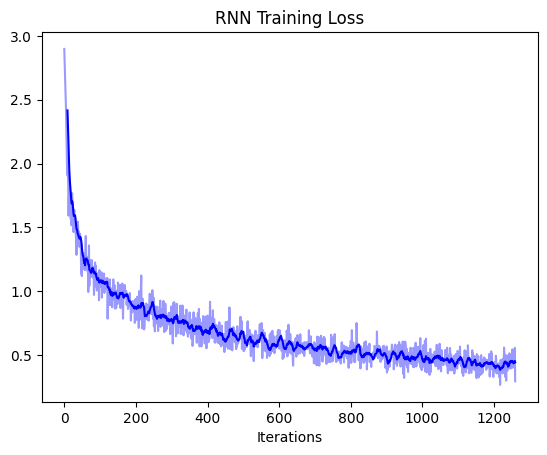

In [228]:
n_steps = len(rnn_log["history"]["train_losses"])
plt.plot(range(n_steps), rnn_log["history"]["train_losses"], alpha=0.4, color="blue")
moving_avg = np.convolve(np.array(rnn_log["history"]["train_losses"]), np.ones(10), 'valid') / 10
plt.plot(range(9, n_steps), moving_avg.tolist(), color="blue")
plt.xlabel("Iterations")
plt.title("RNN Training Loss")
plt.show()

#### Some insights from hyperparameter tunning:
+ Increasing the size of the hidden layer made most of the difference, it allowed for better representational power.
+ Increasing the number of layers in the RNN reduced performance, this is probably due to the vanishing gradients, since in RNNs we do not have a proper mechanism to deal with them.
+ Using small batch sizes lead to noisy updates but it head better generalization, I increased the batch size, learning rate and dropout together to help with both.
+ Sometimes decresing the learning rate lead to more oscillations, which was very surprising, I still do not fully understand why that might be. Maybe just because RNNs are weird with two competing dybamical systems that need fine-tuning.

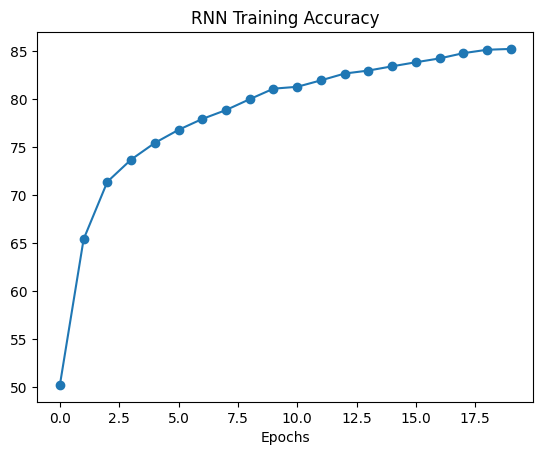

In [218]:
plt.plot(rnn_log["history"]["train_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Training Accuracy")
plt.show()

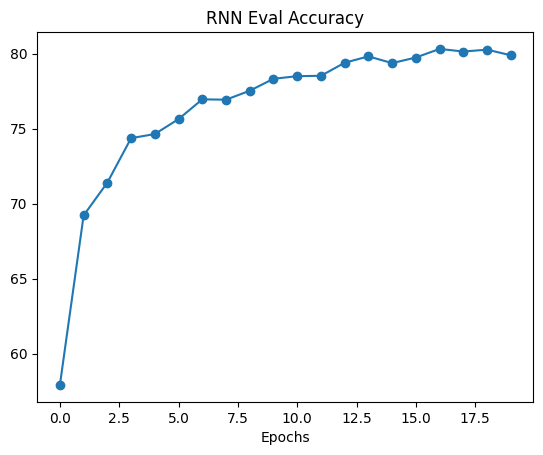

In [219]:
plt.plot(rnn_log["history"]["eval_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Eval Accuracy")
plt.show()

In [220]:
lstm_log = train(lstm_model, lstm_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 59  Loss: 1.7438831210136414: 100%|██████████| 63/63 [00:01<00:00, 39.17it/s]


Epoch: 0  Train Accuracy: 41.60283952923594
Epoch: 0  Eval Accuracy: 48.24408468244085


Epoch: 1  Iteration: 59  Loss: 1.6542933702468872: 100%|██████████| 63/63 [00:01<00:00, 41.52it/s]


Epoch: 1  Train Accuracy: 50.1463353882558
Epoch: 1  Eval Accuracy: 53.05105853051059


Epoch: 2  Iteration: 59  Loss: 1.5119310021400452: 100%|██████████| 63/63 [00:01<00:00, 41.46it/s]


Epoch: 2  Train Accuracy: 53.24740021171929
Epoch: 2  Eval Accuracy: 56.1145703611457


Epoch: 3  Iteration: 59  Loss: 1.447062647342682: 100%|██████████| 63/63 [00:01<00:00, 41.16it/s]


Epoch: 3  Train Accuracy: 57.68105112398032
Epoch: 3  Eval Accuracy: 60.74719800747198


Epoch: 4  Iteration: 59  Loss: 1.3243200659751893: 100%|██████████| 63/63 [00:01<00:00, 40.70it/s]


Epoch: 4  Train Accuracy: 62.18319945202067
Epoch: 4  Eval Accuracy: 64.80697384806973


Epoch: 5  Iteration: 59  Loss: 1.2096181750297545: 100%|██████████| 63/63 [00:01<00:00, 40.57it/s]


Epoch: 5  Train Accuracy: 66.17473068061524
Epoch: 5  Eval Accuracy: 67.34744707347447


Epoch: 6  Iteration: 59  Loss: 1.0852765321731568: 100%|██████████| 63/63 [00:01<00:00, 40.43it/s]


Epoch: 6  Train Accuracy: 69.52487701600349
Epoch: 6  Eval Accuracy: 69.63885429638854


Epoch: 7  Iteration: 59  Loss: 1.0706497609615326: 100%|██████████| 63/63 [00:01<00:00, 39.84it/s]


Epoch: 7  Train Accuracy: 71.62961579176785
Epoch: 7  Eval Accuracy: 70.28642590286425


Epoch: 8  Iteration: 59  Loss: 0.9700029551982879: 100%|██████████| 63/63 [00:01<00:00, 36.68it/s]


Epoch: 8  Train Accuracy: 72.75048259542936
Epoch: 8  Eval Accuracy: 71.98007471980074


Epoch: 9  Iteration: 59  Loss: 0.941328352689743: 100%|██████████| 63/63 [00:01<00:00, 38.93it/s]


Epoch: 9  Train Accuracy: 74.83031322000124
Epoch: 9  Eval Accuracy: 73.49937733499378


Epoch: 10  Iteration: 59  Loss: 0.8834854423999786: 100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch: 10  Train Accuracy: 76.12553708201008
Epoch: 10  Eval Accuracy: 74.17185554171856


Epoch: 11  Iteration: 59  Loss: 0.8050007820129395: 100%|██████████| 63/63 [00:01<00:00, 39.08it/s]


Epoch: 11  Train Accuracy: 77.11563609191107
Epoch: 11  Eval Accuracy: 75.06849315068493


Epoch: 12  Iteration: 59  Loss: 0.8046303033828736: 100%|██████████| 63/63 [00:01<00:00, 38.93it/s]


Epoch: 12  Train Accuracy: 78.03101064823463
Epoch: 12  Eval Accuracy: 75.96513075965132


Epoch: 13  Iteration: 59  Loss: 0.747428560256958: 100%|██████████| 63/63 [00:01<00:00, 38.46it/s]


Epoch: 13  Train Accuracy: 78.90902297776947
Epoch: 13  Eval Accuracy: 76.36363636363637


Epoch: 14  Iteration: 59  Loss: 0.7652399599552154: 100%|██████████| 63/63 [00:01<00:00, 38.63it/s]


Epoch: 14  Train Accuracy: 79.42586711501339
Epoch: 14  Eval Accuracy: 75.89041095890411


Epoch: 15  Iteration: 59  Loss: 0.6583161950111389: 100%|██████████| 63/63 [00:01<00:00, 38.43it/s]


Epoch: 15  Train Accuracy: 79.95516532785354
Epoch: 15  Eval Accuracy: 76.8368617683686


Epoch: 16  Iteration: 59  Loss: 0.6629852592945099: 100%|██████████| 63/63 [00:01<00:00, 38.24it/s]


Epoch: 16  Train Accuracy: 80.60277725885796
Epoch: 16  Eval Accuracy: 77.63387297633872


Epoch: 17  Iteration: 59  Loss: 0.6631174266338349: 100%|██████████| 63/63 [00:01<00:00, 38.48it/s]


Epoch: 17  Train Accuracy: 81.42474624820973
Epoch: 17  Eval Accuracy: 77.88293897882939


Epoch: 18  Iteration: 59  Loss: 0.6312021434307098: 100%|██████████| 63/63 [00:01<00:00, 38.07it/s]


Epoch: 18  Train Accuracy: 81.66760072233639
Epoch: 18  Eval Accuracy: 78.4557907845579


Epoch: 19  Iteration: 59  Loss: 0.6249469429254532: 100%|██████████| 63/63 [00:01<00:00, 38.17it/s]


Epoch: 19  Train Accuracy: 82.01631483903107
Epoch: 19  Eval Accuracy: 78.58032378580324


## Use Your RNN: Try Your Own Name

Attempt to use the code cells below to **predict the origin of your own last name**.

Please refrain from entering the last names of your classmates, as the names you enter will be logged for anti-plagiarism purposes.

In [221]:
def classify_name(name, model):
    '''
    Numerize the name and return the most likely number representation of the
    predicted class.
    '''
    # change this if your last name is longer than 19 characters
    token = np.ones(19, dtype=np.int64) * pad
    numerized = np.array([letterToIndex(l) for l in name])
    n = len(numerized)
    token[:n] = numerized
    print(token)
    logits = model(
        torch.tensor(token, dtype=torch.long)[None, :],
        torch.tensor([n - 1], dtype=torch.long)
    )
    return logits.argmax(dim=-1).item()

In [223]:
model = rnn_model
model.eval()
model.cpu()
############################################################################
# Enter your last name
############################################################################
name = "Fadi"
############################################################################
rnn_log["last_name"] = name
rnn_log["source_init"] = inspect.getsource(RecurrentClassifier.__init__)
rnn_log["source_forward"] = inspect.getsource(RecurrentClassifier.forward)
print("Predicting origin language for name: "+ name)
c = classify_name(name, model)
print(num_to_cat[c])

Predicting origin language for name: Fadi
[31  0  3  8 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
Italian


#### More on RNNs dynamics:

The previously defined architecture, faces the same challenges we face when using layers of $CNN$ mainly those of *dying gradients* and *exploding gradients*, due to the deep nature of this network.


There are several regularization techniques to deal with these challenges. But there's a subtle yet very important distinction we need to make, an explanation of the delicacy of $RNNs$ that goes beyond the argument *'They are just deep'*.

In the case of $RNNs$ we have two dynamical systems we need to make sure are stable.

The first one is that of the optimization dynamics. The gradient descent updates are a dynamical system, we have analysed the convergence  of such system (Through linearization) in [[Gradient Descent Problems; Badly Conditioned Curvature.]] We know how to condition the optimization landscape and how to carefully tune the learning rate to allow for proper convergence.

Another challenge that is inherent to $RNNs$, is the fact that we are using a recurrent relationship in the information propagation, the shared weights and the recurrent relationship create another dynamical system that we would need to keep stable we can again analyse the linear case (Kalman filter), look at the previous equation:
$$\vec{h}_{t+1|t+1} = A\vec{h}_{t|t} + B\vec{x}_{t}$$
The eigenvalues of the matrix $A$ govern the stability of our information propagation system, the stability of these activations, itself  plays a role in the stability of the first system, if this one diverges, the gradient descent dynamical system diverges too.

You can see how there's a deep interplay, that makes dealing with $RNNs$ challenging and needs special delicacy to allow for proper learning.

When we view an $RNN$ as a dynamical system, we're essentially looking at how information evolves over time through repeated application of the same transformation. The key insight is that we want this system to be stable - meaning we don't want the hidden state values to grow unboundedly or chaotically over time sequences.

This stability requirement exists independently of gradient considerations:

- If hidden states explode, we lose meaningful information representation
- If they vanish, we lose the ability to maintain long-term dependencies
- Values less than one help ensure the system converges to meaningful attractors rather than diverging

What's elegant about this perspective is that it shows how the same solution (keeping values bounded) addresses two different but related problems:
1. *Forward pass stability (dynamical systems view)*
2. *Gradient stability (backpropagation view)*

